Load, clean and normalize the data

In [1]:
from scripts.preprocess_data import *
data = load_data()
data = clean_data(data)
data = normalize_data(data)

### Text Length

Average text length: 177.81356390549388
Median text length: 175.0


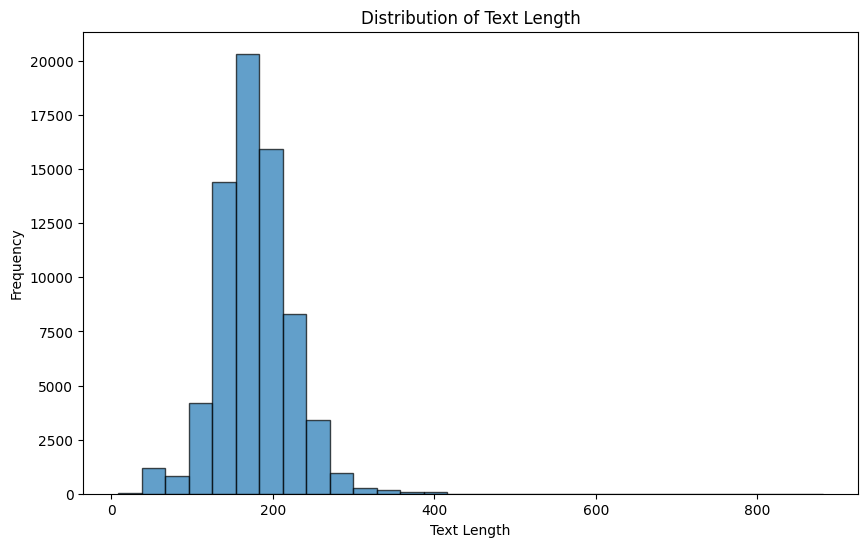

In [5]:
import matplotlib.pyplot as plt

# Compute the length of each text
data['text_length'] = data['text'].apply(len)

# Calculate average and median text length
average_length = data['text_length'].mean()
median_length = data['text_length'].median()

print(f"Average text length: {average_length}")
print(f"Median text length: {median_length}")

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()
